In [1]:
import sys
sys.path.append('..//')

import jax
import jax.numpy as jnp
import numpy as np
import pytest
from functools import partial

from parsmooth._base import MVNStandard, FunctionalModelX, MVNSqrt
from parsmooth.linearization import cubature, extended, gauss_hermite
from parsmooth.methods import iterated_smoothing, filtering, smoothing
from parsmooth.linearization._cubature import _get_sigma_points
from parsmooth.linearization._sigma_points import linearize_functional
from parsmooth._utils import cholesky_update_many, tria

from parsmooth.parallel._filtering import _standard_associative_params
from parsmooth.parallel._filtering import _sqrt_associative_params

from parsmooth.parallel._operators import standard_filtering_operator
from parsmooth.parallel._operators import sqrt_filtering_operator
from parsmooth.parallel._operators import standard_smoothing_operator
from parsmooth.parallel._operators import sqrt_smoothing_operator

from parsmooth.parallel._smoothing import _associative_params

from parsmooth.parallel._operators import standard_smoothing_operator
from parsmooth.parallel._operators import sqrt_smoothing_operator

from bearings.bearings_utils import make_parameters
from bearings.bearingdata import get_data


import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
np.random.seed(0)

In [2]:
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
dt = 0.01  # discretization time step
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise

T = 10  # number of observations

In [3]:
ts, true_states, ys = get_data(x0, dt, r, T, s1, s2, random_state=42)



In [4]:

linearization_method = cubature
jax.config.update("jax_enable_x64", True)
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
dt = 0.01  # discretization time step
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise
Q_, R, observation_function, transition_function = make_parameters(qc, qw, r, dt, s1, s2)

Q = Q_

m0 = jnp.array([-4., -1., 2., 7., 3.])
chol_P0 = jnp.eye(5)
P0 = jnp.eye(5)

chol_Q = jnp.linalg.cholesky(Q)
chol_R = jnp.linalg.cholesky(R)

T = ys.shape[0]
initial_states =  MVNStandard(jnp.repeat(jnp.array([[-1., -1., 6., 4., 2.]]),T, axis=0),
                                                     jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T, axis=0))


initial_states_sqrt = MVNSqrt(jnp.repeat(jnp.array([[-1., -1., 6., 4., 2.]]),T, axis=0),
                              jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T, axis=0))

init = MVNStandard(m0, P0)
chol_init = MVNSqrt(m0, chol_P0)


sqrt_transition_model = FunctionalModelX(transition_function, MVNSqrt(jnp.zeros((5,)), chol_Q))
transition_model = FunctionalModelX(transition_function, MVNStandard(jnp.zeros((5,)), Q))

sqrt_observation_model = FunctionalModelX(observation_function, MVNSqrt(jnp.zeros((2,)), chol_R))
observation_model = FunctionalModelX(observation_function, MVNStandard(jnp.zeros((2,)), R))



In [5]:
# Initialization params in Parallel-Filtering

params_str = _standard_associative_params(linearization_method, transition_model, observation_model,
                                          initial_states, init, ys)
params_sqrt = _sqrt_associative_params(linearization_method, sqrt_transition_model, sqrt_observation_model,
                                       initial_states_sqrt, chol_init, ys)

In [6]:
# (A, b, C, eta , J) v.s (A, b, U, eta, Z)
np.testing.assert_array_almost_equal(params_str[0][0], params_sqrt[0][0], decimal = 7)

np.testing.assert_array_almost_equal(params_str[0][1], params_sqrt[0][1], decimal = 7)

np.testing.assert_array_almost_equal(params_str[0][2],
                                     params_sqrt[0][2] @ np.transpose(params_sqrt[0][2], [0, 2, 1]),
                                     decimal = 6)

np.testing.assert_array_almost_equal(params_str[0][3], params_sqrt[0][3], decimal = 7)

np.testing.assert_array_almost_equal(params_str[0][4],
                                     params_sqrt[0][4] @ np.transpose(params_sqrt[0][4], [0, 2, 1]),
                                     decimal = 7)

In [7]:
sqrt_iterated_res_seq = iterated_smoothing(ys, chol_init, sqrt_transition_model, sqrt_observation_model,
                                  linearization_method, initial_states_sqrt, False,
                                      criterion=lambda i, *_: i < 100)

In [8]:
sqrt_iterated_res_par = iterated_smoothing(ys, chol_init, sqrt_transition_model, sqrt_observation_model,
                                       linearization_method, initial_states_sqrt, True,
                                       criterion=lambda i, *_: i < 100)

In [9]:
iterated_res_seq = iterated_smoothing(ys, init, transition_model, observation_model,
                                      linearization_method, initial_states, False,
                                      criterion=lambda i, *_: i < 100)

In [10]:
iterated_res_par = iterated_smoothing(ys, init, transition_model, observation_model,
                                      linearization_method, initial_states, True,
                                      criterion=lambda i, *_: i < 100)

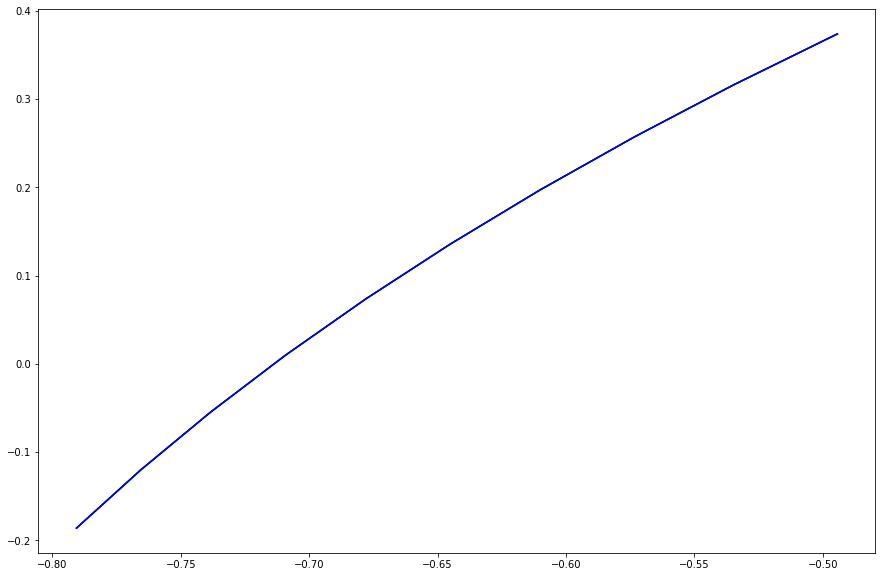

In [11]:
plt.figure(figsize=(15, 10))
plt.plot(sqrt_iterated_res_seq.mean[:,0], sqrt_iterated_res_seq.mean[:,1],'g')
plt.plot(sqrt_iterated_res_par.mean[:,0], sqrt_iterated_res_par.mean[:,1],'k')
plt.plot(iterated_res_seq.mean[:,0], iterated_res_seq.mean[:,1],'b')

In [17]:
np.testing.assert_array_almost_equal(sqrt_iterated_res_seq.mean, sqrt_iterated_res_par.mean, decimal=8)


In [18]:
np.testing.assert_array_almost_equal(sqrt_iterated_res_seq.chol @ np.transpose(sqrt_iterated_res_seq.chol, [0,2,1]),
                                     sqrt_iterated_res_par.chol @ np.transpose(sqrt_iterated_res_par.chol, [0,2,1]), decimal=8)
